In [1]:
#import requests
#import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsRegressor

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
import scipy.stats
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score ,f1_score ,roc_auc_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

In [211]:
from catboost import CatBoostClassifier
from sklearn.model_selection import  StratifiedKFold,train_test_split,cross_val_score
from sklearn.metrics import log_loss,f1_score,roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import  GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
def make_mi_scores_Classif(X_train, y_train):
    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = X_train.dtypes == int
    mi_scores = mutual_info_classif(X_train, y_train, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(20,14))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
def apply_pca(X,alias, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC_{alias}{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    #print( pca.components_)
    return pca, X_pca, loadings

def topk_feat(df,mi_scores,PC,cols,thresh,targets):
    df = df.copy()
    mi_scores = mi_scores.copy()
    topk = mi_scores[mi_scores>thresh].index.to_list()
    base_df = pd.concat([df.loc[:,cols].reset_index(drop=True),PC],axis=1)
    #display(base_df.head(2))
    base_df = base_df[topk]
    out_df = pd.concat([df.loc[:,targets+['Season']].reset_index(drop=True),base_df],axis=1)
    return  out_df

def Ratio(df_def,a,b,ratio_name):
    df_def = df_def.copy()
    new_feature = ratio_name
    df_def[new_feature] = df_def[a]/df_def[b]
    mask = (df_def[b]==0)
    df_def.loc[mask,new_feature]=0 
    return df_def

In [5]:
def Convert_Streak(row):
    if  isinstance(row,int) or isinstance(row,float):
        return 0
    else:
        tokens = row.split(' ')
        if len(tokens) ==2:
            if tokens[0]=='W':
                return int(tokens[1])*1
            if tokens[0]=='L':
                return int(tokens[1])*-1
    
def Rest_days(row):
    if isinstance(row,int) or isinstance(row,float):
        return row
    tokens = row.split(' ')
    return int(tokens[0])

def Convert_Time(row): 
    tokens = row.split(':')
    if len(tokens) ==2:
        return int(tokens[0]) #+ int(tokens[1])/60

def missing_percentage(df):
    """A function for returning missing ratios."""
    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

def rest_and_prev_opp(df):
    df = df.copy()
    gp_arr=[]
    for team,team_df in df.groupby('Team')['Date','Opponent']:
        team_df_shift = team_df.shift(1)
        gp_arr.append(team_df_shift)
    prevs = pd.concat(gp_arr)
    prevs = prevs.sort_index()
    prevs_cols = ['last_game_date','prev_opp']
    prevs.columns = prevs_cols
    df_with_prev = pd.concat([df,prevs],axis=1)
    return df_with_prev 

def played_how_many(df,col):
    df = df.copy()
    gp_arr=[]
    alias='_how_many'
    for team,team_df in df.groupby('Team'):
        #print(team)
        for gp, gp_df in team_df.groupby(col):
            feature_name = col+alias
            gp_df[feature_name] = 1
            gd_cum = gp_df[feature_name].cumsum()
            gp_arr.append(gd_cum)
    cum = pd.concat(gp_arr)
    cum = cum.sort_index()
    #cum.columns = cum_cols
    df_with_cum = pd.concat([df,cum],axis=1)
    return df_with_cum 

def get_cum_by_col(df,grouper,grouper_name,cols,agg_func,fill_na=True):
    df = df.copy()
    gp_arr=[]
    for team,team_df in df.groupby('Team'):
        for g,gd in team_df.groupby([grouper])[cols]:
            #print(g)
            #display(gd)
            if agg_func == 'sum':
                gd_cum = gd.shift(1).cumsum()
            if agg_func == 'mean':
                gd_cum = gd.shift(1).expanding().mean()
            if fill_na == True:
                for col in cols:
                    gd_cum[col].fillna(gd_cum[col].mean(), inplace=True)
            gp_arr.append(gd_cum)
    cum = pd.concat(gp_arr)
    cum = cum.sort_index()
    alias = '_this_'+grouper_name+'_'+agg_func
    cum_cols = [col+alias for col in cols]
    cum.columns = cum_cols
    df_with_cum = pd.concat([df,cum],axis=1)
    return df_with_cum 

def Total_cum_sum(df,cols,agg_func):
    df = df.copy()
    gp_arr=[]
    for team,team_df in df.groupby('Team')[cols]:
        if agg_func == 'sum':
            gd_cum = team_df.shift(1).cumsum()
        if agg_func == 'mean':
            gd_cum = team_df.shift(1).expanding().mean()
        #for col in cols:
            #gd_cum[col].fillna(gd_cum[col].mean(), inplace=True)
        gp_arr.append(gd_cum)
    cum = pd.concat(gp_arr)
    cum = cum.sort_index()
    alias = 'Total_'+agg_func+'_'
    cum_cols = [alias+col for col in cols]
    cum.columns = cum_cols
    df_with_cum = pd.concat([df,cum],axis=1)
    return df_with_cum 

def rolling_average_or_sum(df,cols,window,agg_func):
    df = df.copy()
    alias = '_last_'+str(window)+'gm_'+agg_func
    new_cols = [col+alias for col in cols]
    gp_arr=[]
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            #for g,gd in team_df.groupby([grouper])[cols]:
                if agg_func == 'sum':
                    rolling = team_df[cols].shift(1).rolling(window).sum()
                if agg_func == 'mean':
                    rolling = team_df[cols].shift(1).rolling(window).mean()
                    
                rolling.columns = new_cols   
                gp_arr.append(rolling)
    #display(rolling)
    rolling_df = pd.concat(gp_arr)
    rolling_df = rolling_df.sort_index()
    #rolling.columns = new_cols
    df_rolling = pd.concat([df,rolling_df],axis=1)
    return df_rolling

def get_Cum_Sum_Avg(df,cols,agg_func):
    df = df.copy()
    for col in cols:
        new_feature = col+'_Total_'+agg_func
        if agg_func == 'sum':
            df[new_feature] = df[col].shift(1).cumsum()
        if agg_func == 'mean':
            df[new_feature] = df[col].shift(1).expanding().mean()
    return df

def Cat_Code(df,columns):
    df=df.copy()
    for col in columns:
        new_feature = col+'_code'
        df[new_feature] = df[col].astype("category").cat.codes
    return df

In [6]:
def predictions(data,predictors,targets,model,test_perc=0.25):
    data = data.copy()
    stop = int(test_perc*data.shape[0])
    train = data.loc[:stop,:]
    test = data.loc[stop:,:]
    print('Train_test shape : ',train.shape,'  ',test.shape)
    combination = []
    for target in targets:
        model.fit(train[predictors], train[target])
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        error = accuracy_score(test[target], preds)
        print(f"{target} Accuracy Score : ",error)
        print()
        col ="predicted_"+target
        combined = pd.DataFrame(dict(actual=test[target], predicted=preds))
        combined.columns = ['actual',col]
        combination.append(combined) 
        display(pd.crosstab(index=combined["actual"], columns=combined[col]))
        if target == 'Points':
            print(f"{target} Precision _Macro_Micro : ",precision_score(test[target], preds, average = 'macro'),precision_score(test[target], preds, average = 'micro'))# print("Precision : ",precision_score(test[target], preds))
            print(f"{target} F1_score _Macro_Micro : ",f1_score(test[target], preds, average = 'macro'),f1_score(test[target], preds, average = 'micro'))
            #print(f"{target} ROC _Macro_Micro : ",roc_auc_score(test[target], preds, average = 'macro'),roc_auc_score(test[target], preds, average = 'micro'))
        else:
            print(f"{target} Precision : ",precision_score(test[target], preds))
            print(f"{target} F1_score : ",f1_score(test[target], preds))
            print(f"{target} ROC : ",roc_auc_score(test[target], preds))
        print()
        print()
    combinations = pd.concat(combination,axis=1)
    #combinations = combinations.merge(test[["Team", "Opponent", "Result"]], left_index=True, right_index=True)
    return combinations

In [7]:
df = pd.read_csv("Game//All_team_with_lineups.csv")#, parse_dates=['Date'])
df.shape

(2460, 102)

,Venue,prev_Playoffs,coach_Champ,coach_Conf,coach_W/L%.1,coach_L.1,coach_W.1,coach_G.1,coach_Plyfs,Streak,W_Streak,L_Streak
Total,1230.000000,1148.000000,1066.000000,1066.000000,656.000000,656.000000,656.000000,656.000000,656.000000,30.000000,30.000000,30.000000
Percent,50.000000,46.666667,43.333333,43.333333,26.666667,26.666667,26.666667,26.666667,26.666667,1.219512,1.219512,1.219512


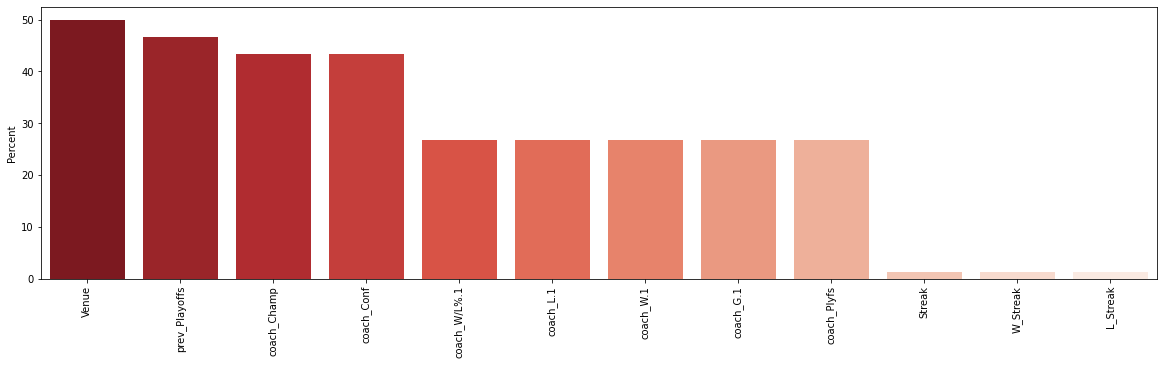

In [8]:
missing = missing_percentage(df)

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='Reds', axis=1))

In [253]:
df.head()

,idx,G,Date,Start (ET),Team_Name,Venue,Opponent,Result,Tm,Opp,W_Streak,L_Streak,Streak,Starting Lineup,Tm_FG,Tm_FGA,Tm_FG%,Tm_3P,Tm_3PA,Tm_3P%,Tm_FT,Tm_FTA,Tm_FT%,Tm_ORB,Tm_TRB,Tm_AST,Tm_STL,Tm_BLK,Tm_TOV,Tm_PF,Opp_FG,Opp_FGA,Opp_FG%,Opp_3P,Opp_3PA,Opp_3P%,Opp_FT,Opp_FTA,Opp_FT%,Opp_ORB,Opp_TRB,Opp_AST,Opp_STL,Opp_BLK,Opp_TOV,Opp_PF,Adv_Tm_ORtg,Adv_Tm_DRtg,Adv_Tm_Pace,Adv_Tm_FTr,Adv_Tm_3PAr,Adv_Tm_TS%,Adv_Tm_TRB%,Adv_Tm_AST%,Adv_Tm_STL%,Adv_Tm_BLK%,Adv_Tm_O_4F_eFG%,Adv_Tm_O_4F_TOV%,Adv_Tm_O_4F_ORB%,Adv_Tm_O_4F_FT/FGA,Adv_Tm_D_4F_eFG%,Adv_Tm_D_4F_TOV%,Adv_Tm_D_4F_DRB%,Adv_Tm_D_4F_FT/FGA,Franchise,H2H_G,H2H_W,H2H_L,H2H_W/L%,H2H_PS,H2H_PA,H2H_PS/G,H2H_PA/G,Coach,coach_From,coach_To,coach_Yrs,coach_G,coach_W,coach_L,coach_W/L%,coach_W > .500,coach_Plyfs,coach_G.1,coach_W.1,coach_L.1,coach_W/L%.1,coach_Conf,coach_Champ,Team,Team_abv,prev_W/L%,prev_Finish,prev_SRS,prev_Pace,prev_Rel_Pace,prev_ORtg,prev_Rel_ORtg,prev_DRtg,prev_Rel_DRtg,prev_Playoffs,prev_Top_WS
0,0,1,"Thu, Oct 21, 2021",7:30p,ATL,NaN,Dallas Mavericks,W,113,87,NaN,NaN,NaN,B. Bogdanović · C. Capela · J. Collins · D. Hu...,45,94,0.479,15,35,0.429,8,9,0.889,6,55,31,8,9,13,16,31,93,0.333,13,43,0.302,12,13,0.923,10,50,16,7,3,15,21,109.9,84.6,102.9,0.096,0.372,0.577,52.4,68.9,7.8,18.0,0.559,11.7,13.0,0.085,0.403,13.2,83.1,0.129,Dallas Mavericks,82,45,37,0.549,8398,8278,102.4,101.0,Nate McMillan,2021,2022,2,120,70,50,0.583,10.0,2.0,23.0,11.0,12.0,0.478,0.0,0.0,AtlantaHawks,ATL,0.569,1st of 5,2.14,97.6,-1.6,115.7,3.4,113.3,1.0,Lost E. Conf. Finals,C. Capela (8.2)
1,1,2,"Sat, Oct 23, 2021",6:00p,ATL,@,Cleveland Cavaliers,L,95,101,1.0,0.0,W 1,B. Bogdanović · C. Capela · J. Collins · D. Hu...,38,99,0.384,10,34,0.294,9,15,0.600,17,54,20,5,3,9,23,37,89,0.416,7,28,0.250,20,27,0.741,12,54,23,6,6,10,16,99.3,105.6,95.7,0.152,0.343,0.450,50.0,52.6,5.2,4.9,0.434,7.9,28.8,0.091,0.455,9.0,75.5,0.225,Cleveland Cavaliers,236,127,109,0.538,24192,24058,102.5,101.9,Nate McMillan,2021,2022,2,120,70,50,0.583,10.0,2.0,23.0,11.0,12.0,0.478,0.0,0.0,AtlantaHawks,ATL,0.569,1st of 5,2.14,97.6,-1.6,115.7,3.4,113.3,1.0,Lost E. Conf. Finals,C. Capela (8.2)
2,2,3,"Mon, Oct 25, 2021",7:30p,ATL,NaN,Detroit Pistons,W,122,104,1.0,1.0,L 1,B. Bogdanović · C. Capela · J. Collins · K. Hu...,46,90,0.511,12,32,0.375,18,21,0.857,10,49,24,11,3,13,19,40,91,0.440,9,33,0.273,15,18,0.833,11,36,26,7,6,14,15,123.1,105.0,99.1,0.233,0.356,0.615,57.6,52.2,11.1,5.2,0.578,11.6,28.6,0.200,0.489,12.4,78.0,0.165,Detroit Pistons,438,213,225,0.486,44340,44530,101.2,101.7,Nate McMillan,2021,2022,2,120,70,50,0.583,10.0,2.0,23.0,11.0,12.0,0.478,0.0,0.0,AtlantaHawks,ATL,0.569,1st of 5,2.14,97.6,-1.6,115.7,3.4,113.3,1.0,Lost E. Conf. Finals,C. Capela (8.2)
3,3,4,"Wed, Oct 27, 2021",7:30p,ATL,@,New Orleans Pelicans,W,102,99,2.0,1.0,W 1,B. Bogdanović · C. Capela · J. Collins · D. Hu...,40,96,0.417,8,30,0.267,14,17,0.824,21,55,21,4,4,11,14,40,93,0.430,11,36,0.306,8,9,0.889,9,44,24,5,6,9,19,110.2,107.0,92.5,0.177,0.313,0.493,55.6,52.5,4.3,7.0,0.458,9.6,37.5,0.146,0.489,8.5,79.1,0.086,New Orleans Pelicans,41,21,20,0.512,3986,4019,97.2,98.0,Nate McMillan,2021,2022,2,120,70,50,0.583,10.0,2.0,23.0,11.0,12.0,0.478,0.0,0.0,AtlantaHawks,ATL,0.569,1st of 5,2.14,97.6,-1.6,115.7,3.4,113.3,1.0,Lost E. Conf. Finals,C. Capela (8.2)
4,4,5,"Thu, Oct 28, 2021",7:00p,ATL,@,Washington Wizards,L,111,122,3.0,1.0,W 2,B. Bogdanović · C. Capela · J. Collins · D. Hu...,48,88,0.545,6,21,0.286,9,14,0.643,6,43,26,4,3,13,16,46,99,0.465,13,34,0.382,17,21,0.810,14,51,26,6,4,6,16,111.9,122.9,99.2,0.159,0.239,0.589,45.7,54.2,4.0,4.6,0.580,12.1,14.0,0.102,0.530,5.3,72.5,0.172,Washington Wizards,312,162,150,0.519,32954,32728,105.6,104.9,Nate McMillan,2021,2022,2,120,70,50,0.583,10.0,2.0,23.0,11.0,12.0,0.478,0.0,0.0,AtlantaHawks,ATL,0.569,1st of 5,2.14,97.6,-1.6,115.7,3.4,113.3,1.0,Lost E. Conf. Finals,C. Capela (8.2)


In [9]:
game_lineups_cols ='idx	G	Date	Start (ET)	Team_Name	Venue	Opponent	Result	Tm	Opp	W_Streak	L_Streak	Streak	Starting Lineup'.split('	')
df[game_lineups_cols].head()

,idx,G,Date,Start (ET),Team_Name,Venue,Opponent,Result,Tm,Opp,W_Streak,L_Streak,Streak,Starting Lineup
0,0,1,"Thu, Oct 21, 2021",7:30p,ATL,NaN,Dallas Mavericks,W,113,87,NaN,NaN,NaN,B. Bogdanović · C. Capela · J. Collins · D. Hu...
1,1,2,"Sat, Oct 23, 2021",6:00p,ATL,@,Cleveland Cavaliers,L,95,101,1.0,0.0,W 1,B. Bogdanović · C. Capela · J. Collins · D. Hu...
2,2,3,"Mon, Oct 25, 2021",7:30p,ATL,NaN,Detroit Pistons,W,122,104,1.0,1.0,L 1,B. Bogdanović · C. Capela · J. Collins · K. Hu...
3,3,4,"Wed, Oct 27, 2021",7:30p,ATL,@,New Orleans Pelicans,W,102,99,2.0,1.0,W 1,B. Bogdanović · C. Capela · J. Collins · D. Hu...
4,4,5,"Thu, Oct 28, 2021",7:00p,ATL,@,Washington Wizards,L,111,122,3.0,1.0,W 2,B. Bogdanović · C. Capela · J. Collins · D. Hu...


In [10]:
def games_trans(df):
    df = df.copy()
    #matches played that day
    df['matches_date_Count'] =  df['Date'].map(df['Date'].value_counts().to_dict())
    
    df['Date'] =  pd.to_datetime(df['Date'] + ' ' + df['Start (ET)'])
    df['Season'] =2022
    df['Day_of_week'] = df.Date.dt.day_of_week
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['Kick_off_hr'] = df.Date.dt.hour
    df['Kick_off_min'] = df.Date.dt.minute
    
    #previous game date and opp
    df = rest_and_prev_opp(df)
    df['Rest'] = (df.Date - df.last_game_date).dt.days
    df['Rest_hrs'] = (df.Date - df.last_game_date).dt.total_seconds()
    df['Rest_hrs'] = df['Rest_hrs']/3600
    df['Rest'].replace(np.nan, 0, inplace=True)
    df['Rest_hrs'].replace(np.nan, 0, inplace=True)
    #win/lose
    df['Win'] = df.apply(lambda x : 1 if x.Result == 'W' else 0 ,axis=1)
    df['Lose'] = df.apply(lambda x : 1 if x.Result == 'L' else 0 ,axis=1)
    #adjust venue
    df['Venue'].replace(np.nan, 'Home', inplace=True)
    df['Venue'].replace('@', 'Away', inplace=True)
    
    #how_many
    df = played_how_many(df,col='Opponent')
    df = played_how_many(df,col='Starting Lineup')
    
    #streak
    df['Streak']  = df.Streak.apply(Convert_Streak)
    
    #Venue like metric
    df['Away_Win'] = df.apply(lambda x : 1 if x.Venue == 'Away' and x.Result == 'W' else 0 ,axis=1)
    df['Away_Loss'] = df.apply(lambda x : 1 if x.Venue == 'Away' and x.Result == 'L' else 0 ,axis=1)
    df['Home_Win'] = df.apply(lambda x : 1 if x.Venue == 'Home' and x.Result == 'W' else 0 ,axis=1)
    df['Home_Loss'] = df.apply(lambda x : 1 if x.Venue == 'Home' and x.Result == 'L' else 0 ,axis=1)
    
    #cummulative
    df = Total_cum_sum(df,cols=['Tm','Opp','Win','Lose'],agg_func='mean')
    df = Total_cum_sum(df,cols=['Win','Lose','Away_Win', 'Away_Loss', 'Home_Win', 'Home_Loss'],agg_func='sum')
    
    #This venue
    df = get_cum_by_col(df,grouper='Venue',grouper_name='venue',cols=['Win','Lose'],agg_func='sum',fill_na=True)
    df = get_cum_by_col(df,grouper='Venue',grouper_name='venue',cols=['Tm','Opp','Win','Lose'],agg_func='mean',fill_na=True)
    #This opponent
    df = get_cum_by_col(df,grouper='Opponent',grouper_name='opponent',cols=['Win','Lose'],agg_func='sum',fill_na=True)
    df = get_cum_by_col(df,grouper='Opponent',grouper_name='opponent',cols=['Tm','Opp','Win','Lose'],agg_func='mean',fill_na=True)
    #This lineups
    df = get_cum_by_col(df,grouper='Starting Lineup',grouper_name='starting5',cols=['Win','Lose'],agg_func='sum',fill_na=True)
    df = get_cum_by_col(df,grouper='Starting Lineup',grouper_name='starting5',cols=['Tm','Opp','Win','Lose'],agg_func='mean',fill_na=True)
    #this month
    df = get_cum_by_col(df,grouper='Month',grouper_name='month',cols=['Win','Lose'],agg_func='sum',fill_na=True)
    df = get_cum_by_col(df,grouper='Month',grouper_name='month',cols=['Tm','Opp','Win','Lose'],agg_func='mean',fill_na=True)
    
    #rolling_avg
    df = rolling_average_or_sum(df,cols=['Tm','Opp','Win','Lose'],window=3,agg_func='mean')
    df = rolling_average_or_sum(df,cols=['Win','Lose','Away_Win', 'Away_Loss', 'Home_Win', 'Home_Loss'],window=3,agg_func='sum')
    
    #line_ups
    df['Start5_Count'] =  df['Starting Lineup'].map(df['Starting Lineup'].value_counts().to_dict())
    
    #cat_codes
    cat_cols='Team_Name	Venue	Opponent'.split('	') + ['Starting Lineup','prev_opp']
    df = Cat_Code(df=df,columns=cat_cols)
    
    #fillna
    with_zero = 'Total_sum_Away_Win	Total_sum_Home_Loss	Total_sum_Home_Win	L_Streak	Total_sum_Away_Loss	W_Streak	Total_sum_Lose	Total_mean_Tm	Total_mean_Lose	Total_sum_Win	Total_mean_Opp	Total_mean_Win'.split('	')
    for col in with_zero:
        df[col].replace(np.nan, 0, inplace=True)
    
    missing = missing_percentage(df)

    fig, ax = plt.subplots(figsize=(20, 5))
    sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
    #plt.show()
    plt.xticks(rotation=90)

    display(missing.T.style.background_gradient(cmap='Reds', axis=1))
    
    return df

,prev_Playoffs,coach_Conf,coach_Champ,coach_W/L%.1,coach_W.1,coach_G.1,coach_Plyfs,coach_L.1,Lose_this_starting5_mean,Win_this_starting5_sum,Lose_this_starting5_sum,Tm_this_starting5_mean,Opp_this_starting5_mean,Win_this_starting5_mean,Away_Loss_last_3gm_sum,Home_Loss_last_3gm_sum,Home_Win_last_3gm_sum,Win_last_3gm_sum,Tm_last_3gm_mean,Opp_last_3gm_mean,Win_last_3gm_mean,Lose_last_3gm_mean,Lose_last_3gm_sum,Away_Win_last_3gm_sum,prev_opp,last_game_date
Total,1148.000000,1066.000000,1066.000000,656.000000,656.000000,656.000000,656.000000,656.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,30.000000,30.000000
Percent,46.666667,43.333333,43.333333,26.666667,26.666667,26.666667,26.666667,26.666667,16.016260,16.016260,16.016260,16.016260,16.016260,16.016260,3.658537,3.658537,3.658537,3.658537,3.658537,3.658537,3.658537,3.658537,3.658537,3.658537,1.219512,1.219512


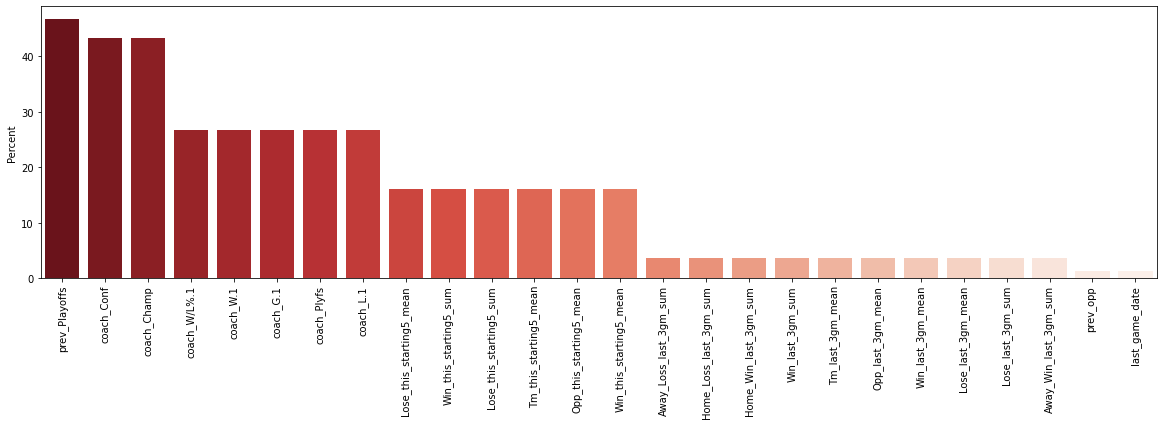

In [11]:
df1 = games_trans(df=df)

In [12]:
df1.head()

,idx,G,Date,Start (ET),Team_Name,Venue,Opponent,Result,Tm,Opp,W_Streak,L_Streak,Streak,Starting Lineup,Tm_FG,Tm_FGA,Tm_FG%,Tm_3P,Tm_3PA,Tm_3P%,Tm_FT,Tm_FTA,Tm_FT%,Tm_ORB,Tm_TRB,Tm_AST,Tm_STL,Tm_BLK,Tm_TOV,Tm_PF,Opp_FG,Opp_FGA,Opp_FG%,Opp_3P,Opp_3PA,Opp_3P%,Opp_FT,Opp_FTA,Opp_FT%,Opp_ORB,Opp_TRB,Opp_AST,Opp_STL,Opp_BLK,Opp_TOV,Opp_PF,Adv_Tm_ORtg,Adv_Tm_DRtg,Adv_Tm_Pace,Adv_Tm_FTr,Adv_Tm_3PAr,Adv_Tm_TS%,Adv_Tm_TRB%,Adv_Tm_AST%,Adv_Tm_STL%,Adv_Tm_BLK%,Adv_Tm_O_4F_eFG%,Adv_Tm_O_4F_TOV%,Adv_Tm_O_4F_ORB%,Adv_Tm_O_4F_FT/FGA,Adv_Tm_D_4F_eFG%,Adv_Tm_D_4F_TOV%,Adv_Tm_D_4F_DRB%,Adv_Tm_D_4F_FT/FGA,Franchise,H2H_G,H2H_W,H2H_L,H2H_W/L%,H2H_PS,H2H_PA,H2H_PS/G,H2H_PA/G,Coach,coach_From,coach_To,coach_Yrs,coach_G,coach_W,coach_L,coach_W/L%,coach_W > .500,coach_Plyfs,coach_G.1,coach_W.1,coach_L.1,coach_W/L%.1,coach_Conf,coach_Champ,Team,Team_abv,prev_W/L%,prev_Finish,prev_SRS,prev_Pace,prev_Rel_Pace,prev_ORtg,prev_Rel_ORtg,prev_DRtg,prev_Rel_DRtg,prev_Playoffs,prev_Top_WS,matches_date_Count,Season,Day_of_week,Month,Day,Kick_off_hr,Kick_off_min,last_game_date,prev_opp,Rest,Rest_hrs,Win,Lose,Opponent_how_many,Starting Lineup_how_many,Away_Win,Away_Loss,Home_Win,Home_Loss,Total_mean_Tm,Total_mean_Opp,Total_mean_Win,Total_mean_Lose,Total_sum_Win,Total_sum_Lose,Total_sum_Away_Win,Total_sum_Away_Loss,Total_sum_Home_Win,Total_sum_Home_Loss,Win_this_venue_sum,Lose_this_venue_sum,Tm_this_venue_mean,Opp_this_venue_mean,Win_this_venue_mean,Lose_this_venue_mean,Win_this_opponent_sum,Lose_this_opponent_sum,Tm_this_opponent_mean,Opp_this_opponent_mean,Win_this_opponent_mean,Lose_this_opponent_mean,Win_this_starting5_sum,Lose_this_starting5_sum,Tm_this_starting5_mean,Opp_this_starting5_mean,Win_this_starting5_mean,Lose_this_starting5_mean,Win_this_month_sum,Lose_this_month_sum,Tm_this_month_mean,Opp_this_month_mean,Win_this_month_mean,Lose_this_month_mean,Tm_last_3gm_mean,Opp_last_3gm_mean,Win_last_3gm_mean,Lose_last_3gm_mean,Win_last_3gm_sum,Lose_last_3gm_sum,Away_Win_last_3gm_sum,Away_Loss_last_3gm_sum,Home_Win_last_3gm_sum,Home_Loss_last_3gm_sum,Start5_Count,Team_Name_code,Venue_code,Opponent_code,Starting Lineup_code,prev_opp_code
0,0,1,2021-10-21 19:30:00,7:30p,ATL,Home,Dallas Mavericks,W,113,87,0.0,0.0,0,B. Bogdanović · C. Capela · J. Collins · D. Hu...,45,94,0.479,15,35,0.429,8,9,0.889,6,55,31,8,9,13,16,31,93,0.333,13,43,0.302,12,13,0.923,10,50,16,7,3,15,21,109.9,84.6,102.9,0.096,0.372,0.577,52.4,68.9,7.8,18.0,0.559,11.7,13.0,0.085,0.403,13.2,83.1,0.129,Dallas Mavericks,82,45,37,0.549,8398,8278,102.4,101.0,Nate McMillan,2021,2022,2,120,70,50,0.583,10.0,2.0,23.0,11.0,12.0,0.478,0.0,0.0,AtlantaHawks,ATL,0.569,1st of 5,2.14,97.6,-1.6,115.7,3.4,113.3,1.0,Lost E. Conf. Finals,C. Capela (8.2),6,2022,3,10,21,19,30,NaT,NaN,0.0,0.0,1,0,1,1,0,0,1,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,12.175,8.325,114.107051,108.022477,0.644944,0.355056,1.0,0.0,113.000000,87.000000,1.000000,0.000000,2.363636,3.636364,105.804254,104.047570,0.479664,0.520336,2.0,1.0,108.72,95.736667,0.703333,0.296667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,0,1,6,70,-1
1,1,2,2021-10-23 18:00:00,6:00p,ATL,Away,Cleveland Cavaliers,L,95,101,1.0,0.0,1,B. Bogdanović · C. Capela · J. Collins · D. Hu...,38,99,0.384,10,34,0.294,9,15,0.600,17,54,20,5,3,9,23,37,89,0.416,7,28,0.250,20,27,0.741,12,54,23,6,6,10,16,99.3,105.6,95.7,0.152,0.343,0.450,50.0,52.6,5.2,4.9,0.434,7.9,28.8,0.091,0.455,9.0,75.5,0.225,Cleveland Cavaliers,236,127,109,0.538,24192,24058,102.5,101.9,Nate McMillan,2021,2022,2,120,70,50,0.583,10.0,2.0,23.0,11.0,12.0,0.478,0.0,0.0,AtlantaHawks,ATL,0.569,1st of 5,2.14,97.6,-1.6,115.7,3.4,113.3,1.0,Lost E. Conf. Finals,C. Capela (8.2),16,2022,5,10,23,18,0,2021-10-21 19:30:00,Dallas Mavericks,1.0,46.5,0,1,1,2,0,1,0,0,113.0,87.000000,1.000000,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,7.675,12.825,107.757432,111.479889,0.344076,0.655924,1.0,1.0,105.444444,107.388889,0.388889,0.611111,1.000000,0.000000,113.000000,87.000000,1.000000,0.000000,1.0,0.0,113.00,87.000000,1.000000,0.000000,NaN,NaN

In [15]:
pd.DataFrame(df1.groupby(['Team','Opponent'])['Tm','Opp'].agg('mean'))

Tm     Opp
Team              Opponent                                  
AtlantaHawks      Boston Celtics          102.750000  100.75
                  Brooklyn Nets           111.666667  115.00
                  Charlotte Hornets       115.250000  110.50
                  Chicago Bulls           118.250000  124.25
                  Cleveland Cavaliers     117.750000  110.50
...                                              ...     ...
WashingtonWizards Portland Trail Blazers  114.000000  121.00
                  Sacramento Kings        107.500000  121.00
                  San Antonio Spurs       126.000000  136.50
                  Toronto Raptors          98.250000  100.75
                  Utah Jazz               103.500000  113.00

[870 rows x 2 columns]

In [219]:
useful_cols = 'G	W_Streak	L_Streak	Streak	matches_date_Count	Day_of_week	Month	Day	Kick_off_hr	Kick_off_min	Rest	Rest_hrs	Win	Lose	Opponent_how_many	Starting Lineup_how_many	Total_mean_Tm	Total_mean_Opp	Total_mean_Win	Total_mean_Lose	Total_sum_Win	Total_sum_Lose	Total_sum_Away_Win	Total_sum_Away_Loss	Total_sum_Home_Win	Total_sum_Home_Loss	Win_this_venue_sum	Lose_this_venue_sum	Tm_this_venue_mean	Opp_this_venue_mean	Win_this_venue_mean	Lose_this_venue_mean	Win_this_opponent_sum	Lose_this_opponent_sum	Tm_this_opponent_mean	Opp_this_opponent_mean	Win_this_opponent_mean	Lose_this_opponent_mean	Win_this_starting5_sum	Lose_this_starting5_sum	Tm_this_starting5_mean	Opp_this_starting5_mean	Win_this_starting5_mean	Lose_this_starting5_mean	Win_this_month_sum	Lose_this_month_sum	Tm_this_month_mean	Opp_this_month_mean	Win_this_month_mean	Lose_this_month_mean	Tm_last_3gm_mean	Opp_last_3gm_mean	Win_last_3gm_mean	Lose_last_3gm_mean	Win_last_3gm_sum	Lose_last_3gm_sum	Away_Win_last_3gm_sum	Away_Loss_last_3gm_sum	Home_Win_last_3gm_sum	Home_Loss_last_3gm_sum	Start5_Count	Team_Name_code	Venue_code	Opponent_code	Starting Lineup_code	prev_opp_code'.split('\t')

In [209]:
useful_cols

['W_Streak',
 'L_Streak',
 'Streak',
 'matches_date_Count',
 'Day_of_week',
 'Month',
 'Day',
 'Kick_off_hr',
 'Kick_off_min',
 'Rest',
 'Rest_hrs',
 'Win',
 'Lose',
 'Opponent_how_many',
 'Starting Lineup_how_many',
 'Total_mean_Tm',
 'Total_mean_Opp',
 'Total_mean_Win',
 'Total_mean_Lose',
 'Total_sum_Win',
 'Total_sum_Lose',
 'Total_sum_Away_Win',
 'Total_sum_Away_Loss',
 'Total_sum_Home_Win',
 'Total_sum_Home_Loss',
 'Win_this_venue_sum',
 'Lose_this_venue_sum',
 'Tm_this_venue_mean',
 'Opp_this_venue_mean',
 'Win_this_venue_mean',
 'Lose_this_venue_mean',
 'Win_this_opponent_sum',
 'Lose_this_opponent_sum',
 'Tm_this_opponent_mean',
 'Opp_this_opponent_mean',
 'Win_this_opponent_mean',
 'Lose_this_opponent_mean',
 'Win_this_starting5_sum',
 'Lose_this_starting5_sum',
 'Tm_this_starting5_mean',
 'Opp_this_starting5_mean',
 'Win_this_starting5_mean',
 'Lose_this_starting5_mean',
 'Win_this_month_sum',
 'Lose_this_month_sum',
 'Tm_this_month_mean',
 'Opp_this_month_mean',
 'Win_this_

,Lose_this_starting5_mean,Win_this_starting5_mean,Opp_this_starting5_mean,Win_this_starting5_sum,Lose_this_starting5_sum,Tm_this_starting5_mean,Tm_last_3gm_mean,Win_last_3gm_sum,Opp_last_3gm_mean,Win_last_3gm_mean,Lose_last_3gm_mean,Away_Win_last_3gm_sum,Lose_last_3gm_sum,Away_Loss_last_3gm_sum,Home_Win_last_3gm_sum,Home_Loss_last_3gm_sum
Total,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
Percent,16.016260,16.016260,16.016260,16.016260,16.016260,16.016260,3.658537,3.658537,3.658537,3.658537,3.658537,3.658537,3.658537,3.658537,3.658537,3.658537


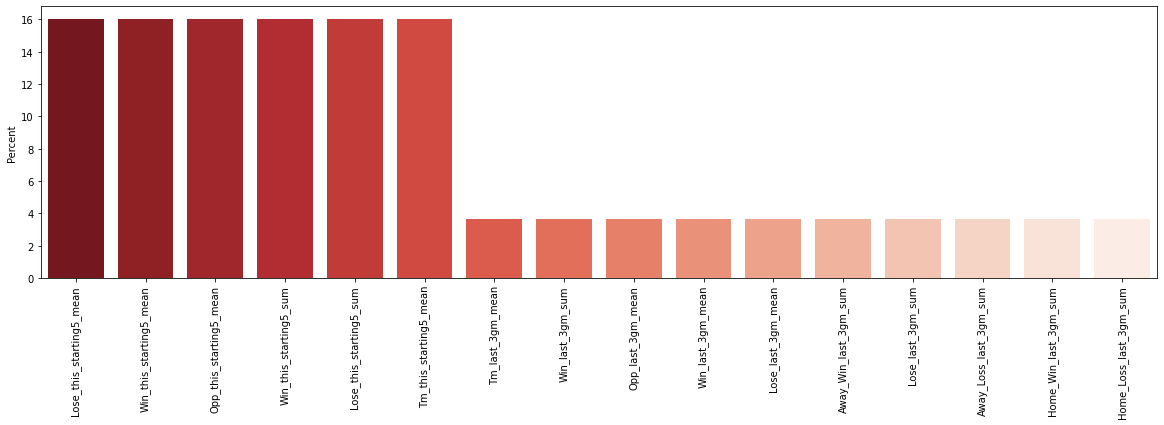

In [221]:
    missing = missing_percentage(df1[useful_cols])

    fig, ax = plt.subplots(figsize=(20, 5))
    sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
    #plt.show()
    plt.xticks(rotation=90)

    display(missing.T.style.background_gradient(cmap='Reds', axis=1))

In [222]:
df1[useful_cols].shape ,df1[useful_cols].dropna().shape

((2460, 66), (1982, 66))

In [224]:
df2 = df1[useful_cols]
df2 = df2.dropna()

In [225]:
df2.shape

(1982, 66)

In [231]:
0.25*1982

495.5

In [234]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=10, random_state=1)

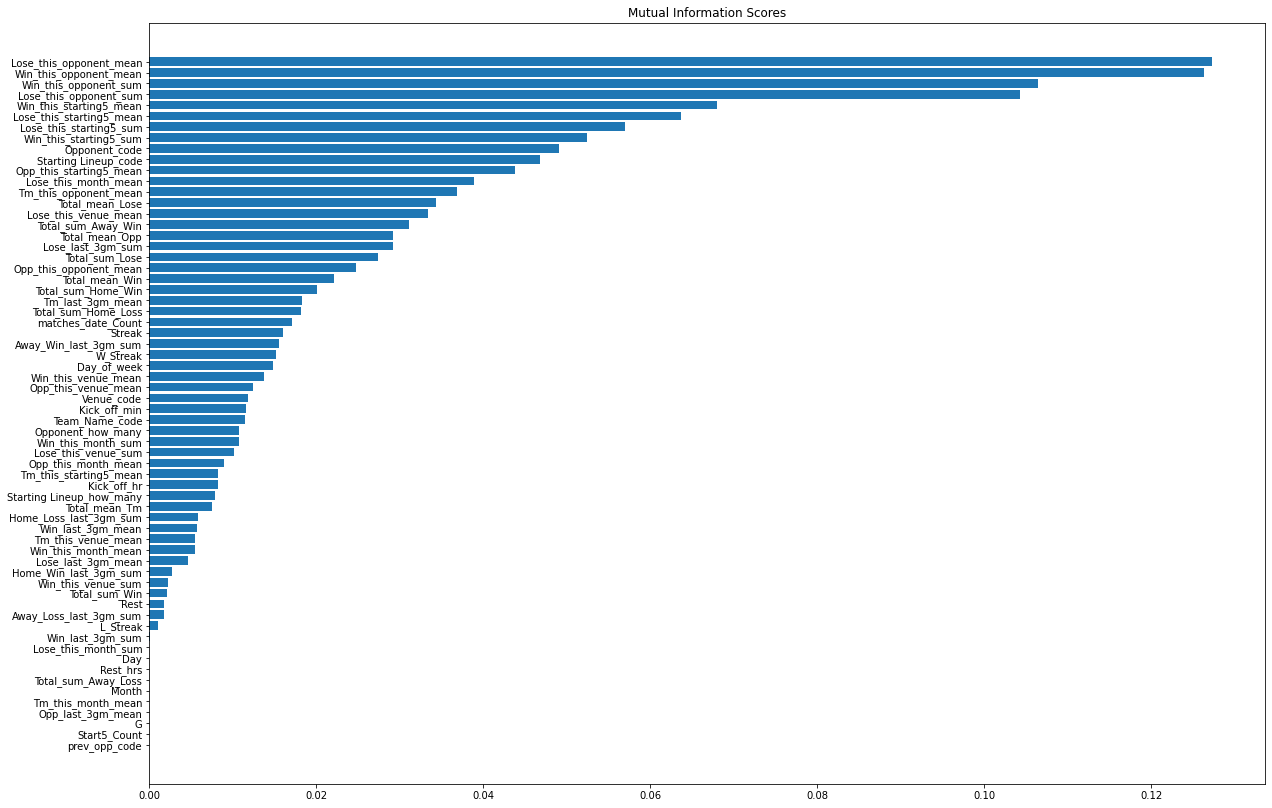

In [242]:
mi_scores_1 = make_mi_scores_Classif(X_train=df2.drop(['Win','Lose'],axis=1), y_train=df2['Win'])
plot_mi_scores(scores=mi_scores_1)

In [243]:
topk = mi_scores_1[mi_scores_1>0].index.to_list()

In [244]:
predictions(data=df2, predictors=topk, targets=['Win','Lose'], model=rf)

Train_test shape :  (389, 66)    (1594, 66)
Win Accuracy Score :  0.6938519447929736



predicted_Win,0.0,1.0
actual,,
0,591,195
1,293,515


Win Precision :  0.7253521126760564
Win F1_score :  0.6785243741765482
Win ROC :  0.6946423172851636


Lose Accuracy Score :  0.657465495608532



predicted_Lose,0.0,1.0
actual,,
0,760,48
1,498,288


Lose Precision :  0.8571428571428571
Lose F1_score :  0.5133689839572193
Lose ROC :  0.6535031365731993




,actual,predicted_Win,actual,predicted_Lose
495,1,1.0,0,0.0
496,0,0.0,1,1.0
498,0,0.0,1,1.0
499,1,1.0,0,0.0
500,1,1.0,0,0.0
...,...,...,...,...
2455,1,1.0,0,0.0
2456,0,0.0,1,0.0
2457,0,1.0,1,0.0
2458,0,1.0,1,0.0


In [245]:
predictions(data=df2, predictors=df2.columns.drop(['Win','Lose']), targets=['Win','Lose'], model=rf)

Train_test shape :  (389, 66)    (1594, 66)
Win Accuracy Score :  0.6900878293601004



predicted_Win,0.0,1.0
actual,,
0,569,217
1,277,531


Win Precision :  0.7098930481283422
Win F1_score :  0.6825192802056556
Win ROC :  0.6905483964426977


Lose Accuracy Score :  0.6524466750313677



predicted_Lose,0.0,1.0
actual,,
0,754,54
1,500,286


Lose Precision :  0.8411764705882353
Lose F1_score :  0.5079928952042629
Lose ROC :  0.6485180006550273




,actual,predicted_Win,actual,predicted_Lose
495,1,1.0,0,0.0
496,0,0.0,1,1.0
498,0,0.0,1,1.0
499,1,1.0,0,0.0
500,1,1.0,0,0.0
...,...,...,...,...
2455,1,1.0,0,0.0
2456,0,0.0,1,0.0
2457,0,1.0,1,0.0
2458,0,1.0,1,0.0


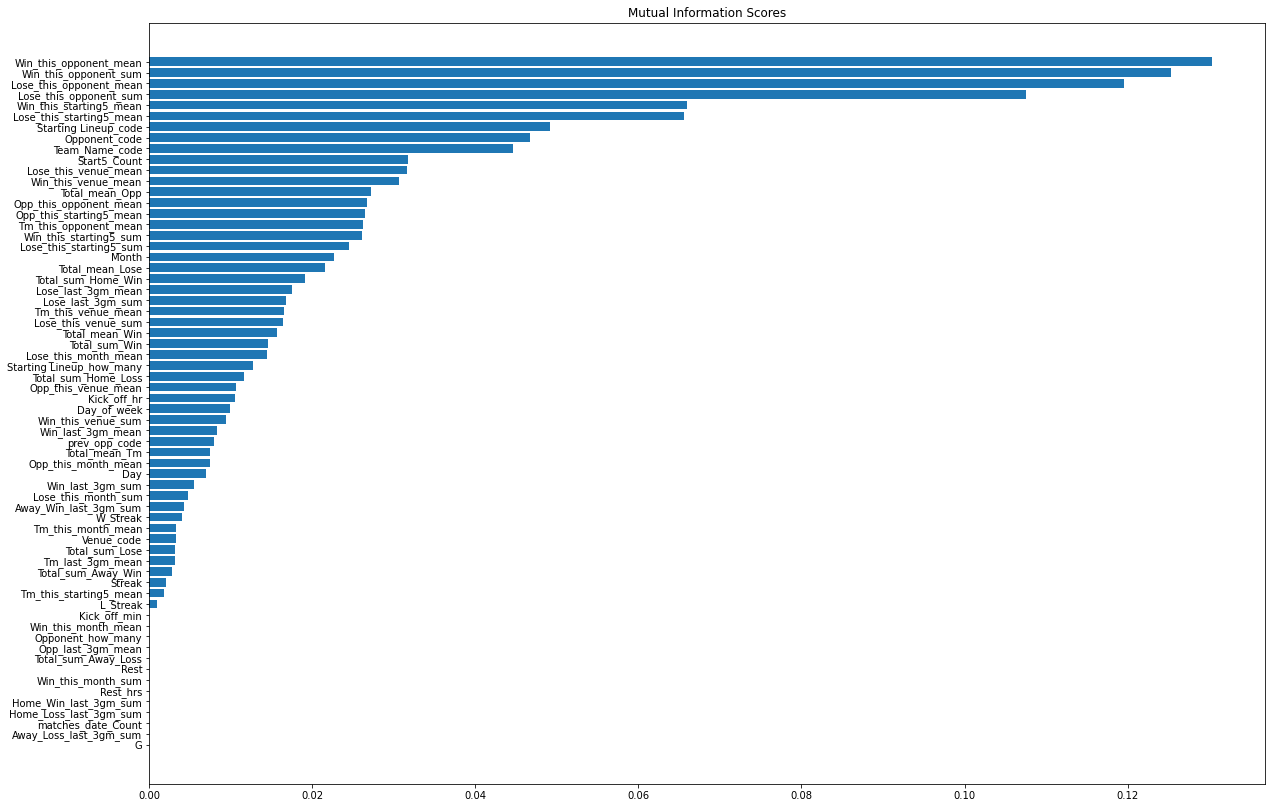

In [246]:
mi_scores_1 = make_mi_scores_Classif(X_train=df2.drop(['Win','Lose'],axis=1), y_train=df2['Lose'])
plot_mi_scores(scores=mi_scores_1)

In [247]:
topk = mi_scores_1[mi_scores_1>0].index.to_list()

In [248]:
predictions(data=df2, predictors=topk, targets=['Win','Lose'], model=rf)

Train_test shape :  (389, 66)    (1594, 66)
Win Accuracy Score :  0.6900878293601004



predicted_Win,0.0,1.0
actual,,
0,586,200
1,294,514


Win Precision :  0.7198879551820728
Win F1_score :  0.6754270696452037
Win ROC :  0.6908428438263673


Lose Accuracy Score :  0.6562107904642409



predicted_Lose,0.0,1.0
actual,,
0,736,72
1,476,310


Lose Precision :  0.8115183246073299
Lose F1_score :  0.5308219178082192
Lose ROC :  0.6526465623661604




,actual,predicted_Win,actual,predicted_Lose
495,1,1.0,0,0.0
496,0,0.0,1,1.0
498,0,0.0,1,1.0
499,1,1.0,0,0.0
500,1,1.0,0,0.0
...,...,...,...,...
2455,1,1.0,0,0.0
2456,0,1.0,1,0.0
2457,0,1.0,1,0.0
2458,0,1.0,1,0.0


In [249]:
predictions(data=df2, predictors=df2.columns.drop(['Win','Lose']), targets=['Win','Lose'], model=rf)

Train_test shape :  (389, 66)    (1594, 66)
Win Accuracy Score :  0.6900878293601004



predicted_Win,0.0,1.0
actual,,
0,569,217
1,277,531


Win Precision :  0.7098930481283422
Win F1_score :  0.6825192802056556
Win ROC :  0.6905483964426977


Lose Accuracy Score :  0.6524466750313677



predicted_Lose,0.0,1.0
actual,,
0,754,54
1,500,286


Lose Precision :  0.8411764705882353
Lose F1_score :  0.5079928952042629
Lose ROC :  0.6485180006550273




,actual,predicted_Win,actual,predicted_Lose
495,1,1.0,0,0.0
496,0,0.0,1,1.0
498,0,0.0,1,1.0
499,1,1.0,0,0.0
500,1,1.0,0,0.0
...,...,...,...,...
2455,1,1.0,0,0.0
2456,0,0.0,1,0.0
2457,0,1.0,1,0.0
2458,0,1.0,1,0.0


### Improvements

    * get rolling average of all the stats features
    * use the coach data and previous season data
    * The H2H data may cause data leakage
    * apply PCA for both feature creation and dimensionality reduction
    * run front test and back test
    * most important is to scrape data from previous seasons
    * combine wins and losses prediction and train with a simple model i.e Linear regression to get a better model